In [ ]:
package_version(R.version)
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("GEOquery")

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("limma")

install.packages("umap")

install.packages("maptools")

Found 1 file(s)

GSE57338_series_matrix.txt.gz

Using locally cached version: /tmp/RtmpuXXsOe/GSE57338_series_matrix.txt.gz

Using locally cached version of GPL11532 found here:
/tmp/RtmpuXXsOe/GPL11532.annot.gz 



"ID"	"adj.P.Val"	"P.Value"	"t"	"B"	"logFC"	"Gene.symbol"	"Gene.title"
7975779	0.00498650763839302	2.02077171559116e-07	5.40848890903908	6.59158453313291	1.03760447928884	"FOS"	"Fos proto-oncogene, AP-1 transcription factor subunit"
7916609	0.00498650763839302	2.99516931759199e-07	5.32600101227028	6.24348227730773	0.277269568331966	"JUN"	"Jun proto-oncogene, AP-1 transcription factor subunit"
8108370	0.0102819821688157	1.39359443692162e-06	4.99510291698909	4.8854526525035	0.725441821437229	"EGR1"	"early growth response 1"
8023361	0.0102819821688157	1.46476257276111e-06	4.98413513332085	4.84152062356196	0.257244047651092	"MRO"	"maestro"
7893271	0.0102819821688157	1.60478494420217e-06	-4.96398776189402	4.7610040172456	-0.193615104557507	""	""
8029693	0.0102819821688157	1.8527763165719e-06	4.93216218746204	4.63430615199984	0.844114999327215	"FOSB"	"FosB proto-oncogene, AP-1 transcription factor subunit"
8082431	0.0120010077475483	2.52296165518931e-06	4.86329485315397	4.36221111540309	0.084

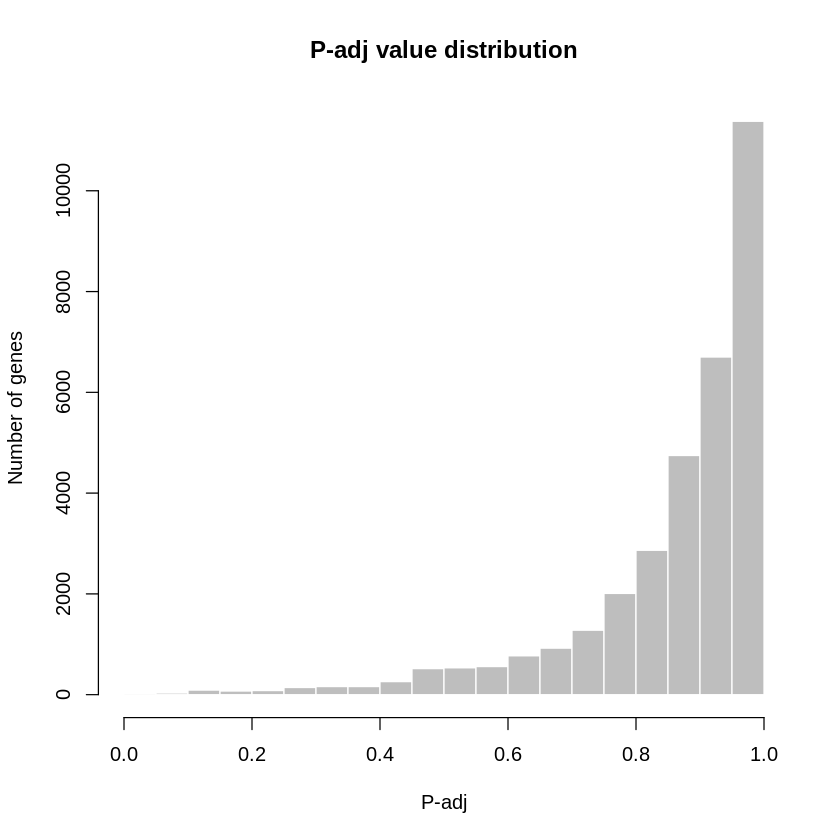

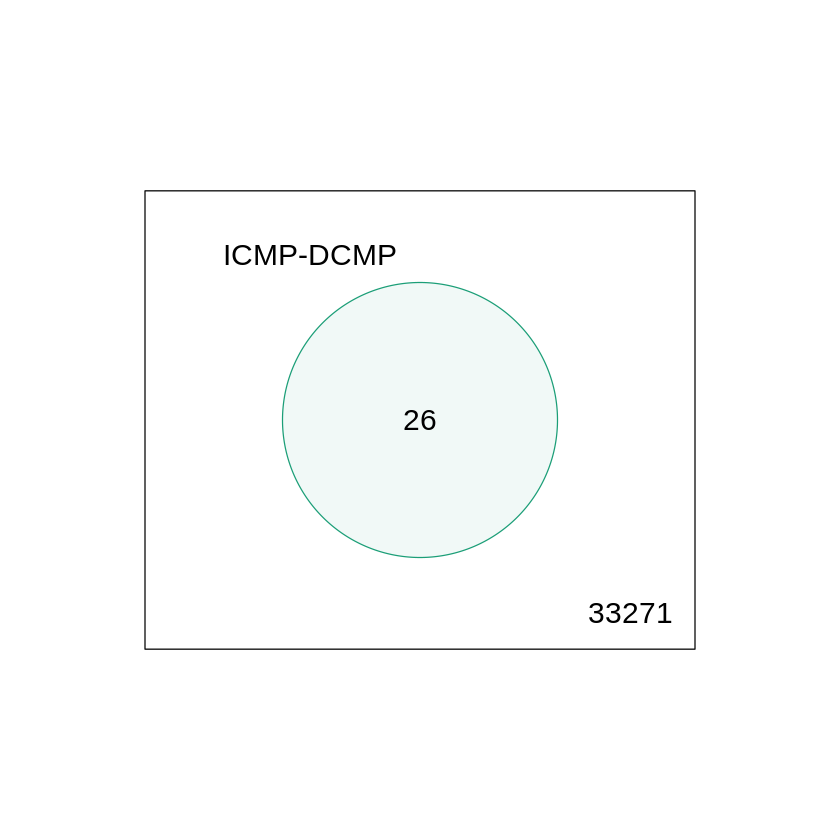

[1] "ICMP-DCMP"

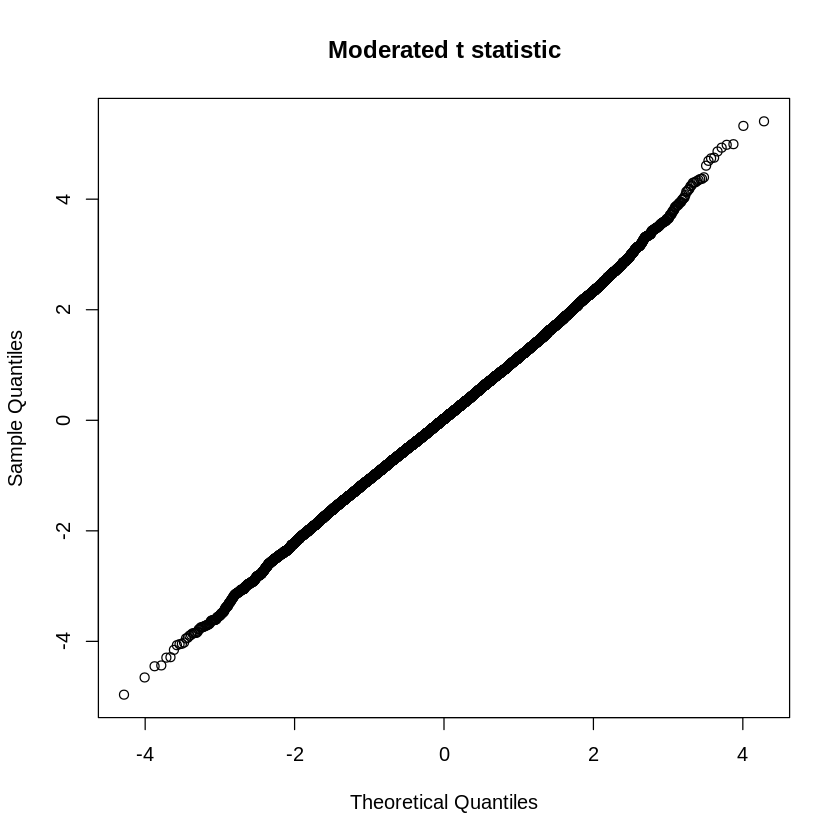

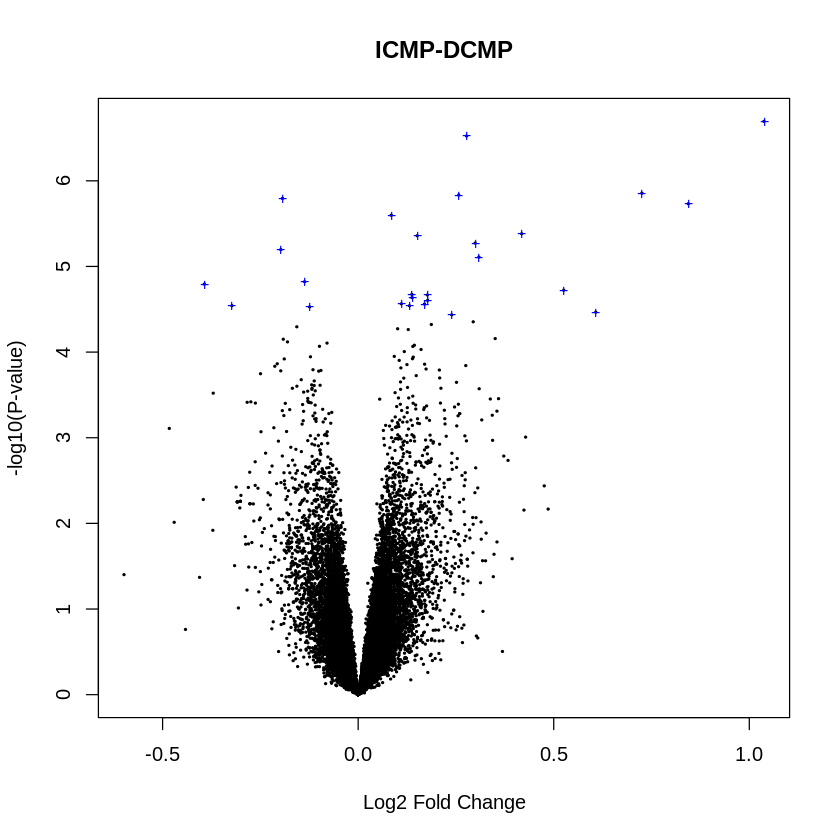

png 
  2

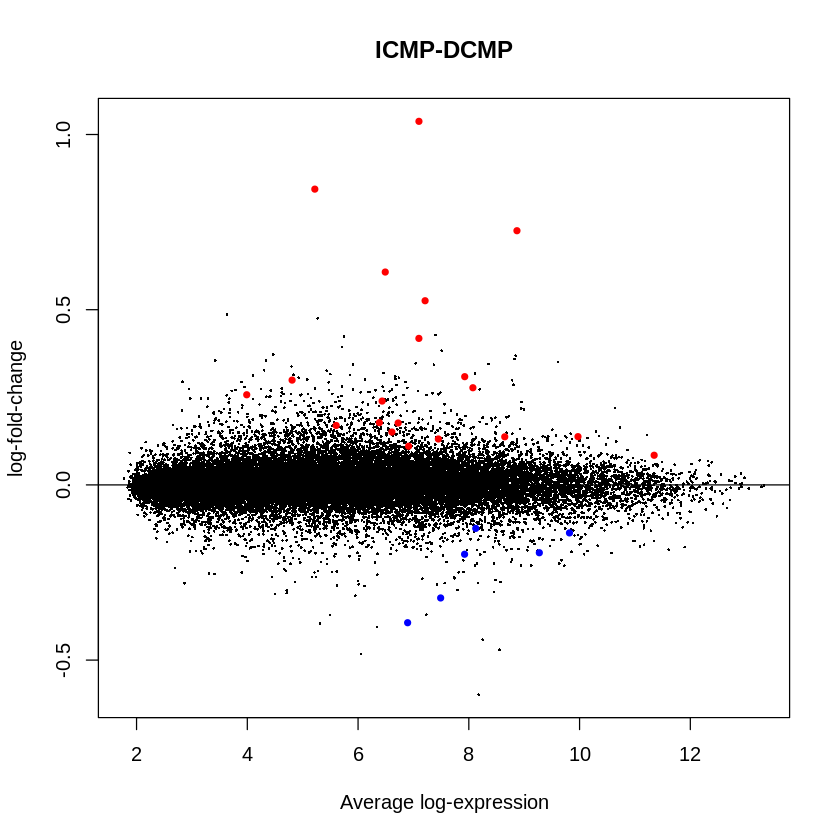

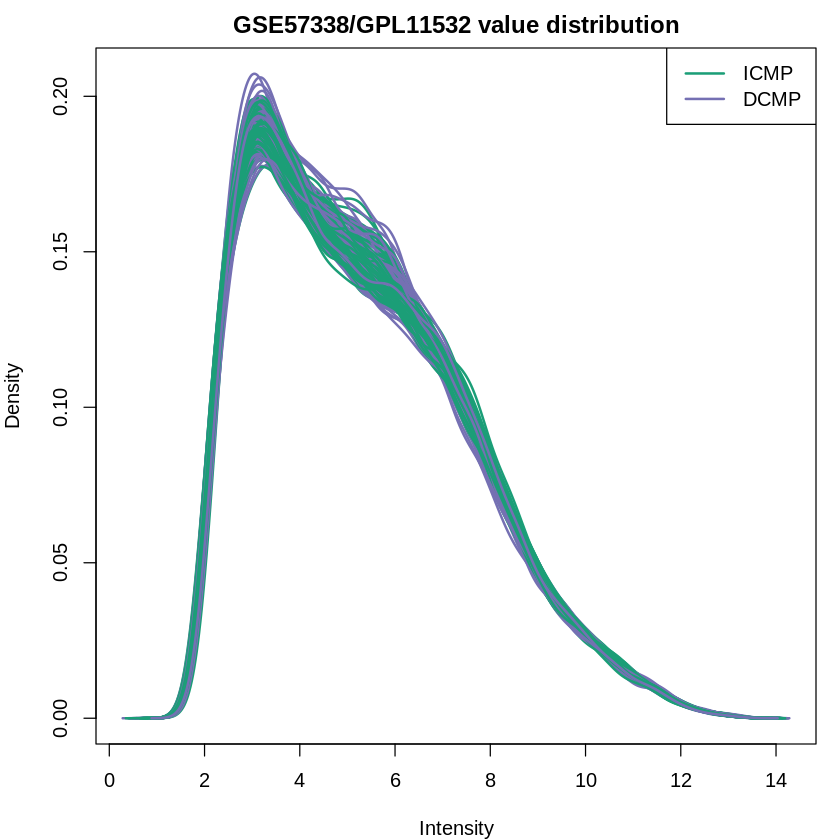

Loading required package: sp

Checking rgeos availability: FALSE
Please note that 'maptools' will be retired by the end of 2023,
plan transition at your earliest convenience;
some functionality will be moved to 'sp'.
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()



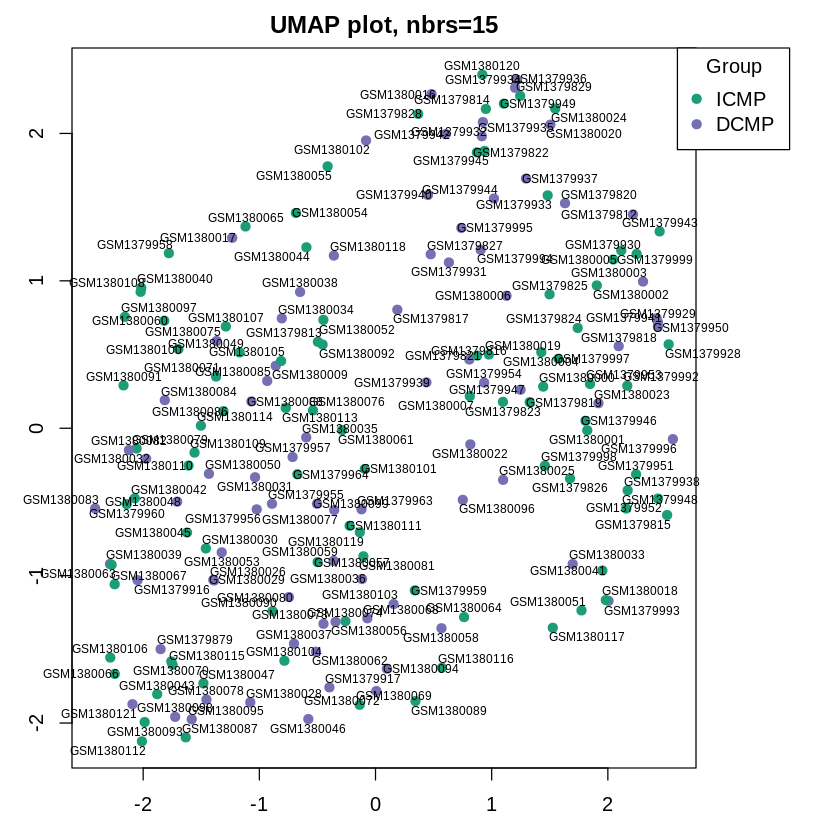

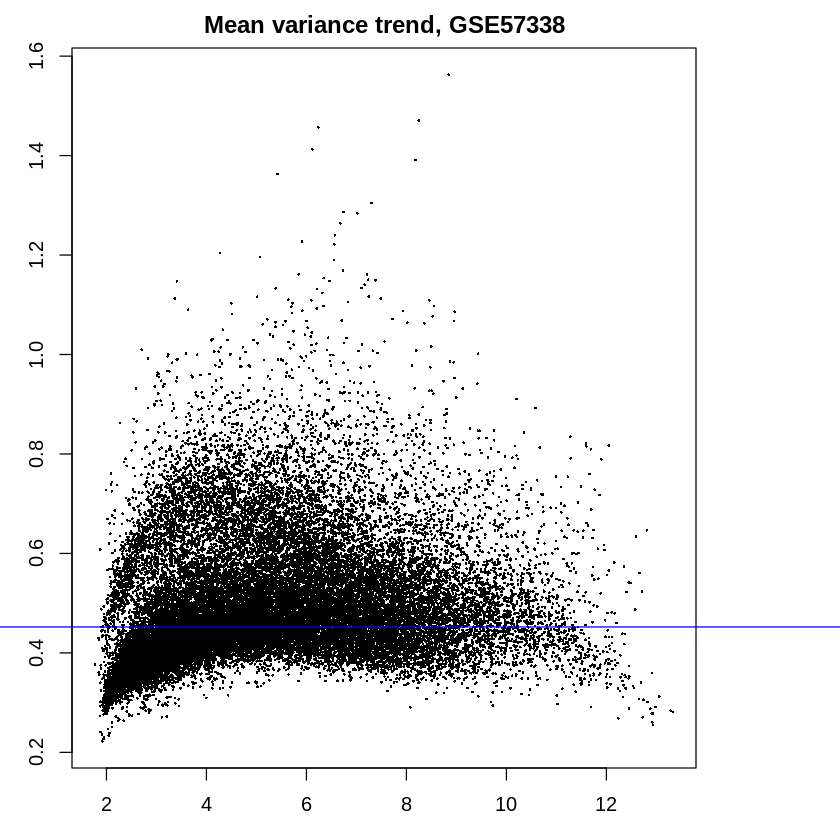

In [11]:
# Version info: R 3.2.3, Biobase 2.30.0, GEOquery 2.40.0, limma 3.26.8
################################################################
#   Differential expression analysis with limma

library(GEOquery)
library(limma)
library(umap)

# load series and platform data from GEO

gset <- getGEO("GSE57338", GSEMatrix =TRUE, AnnotGPL=TRUE)
if (length(gset) > 1) idx <- grep("GPL11532", attr(gset, "names")) else idx <- 1
gset <- gset[[idx]]

# make proper column names to match toptable 
fvarLabels(gset) <- make.names(fvarLabels(gset))

# group membership for all samples
gsms <- paste0("100011101000000100XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXXXX1XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXX11XXXXXXXXXX010110111101111010010010001111000X",
        "X10XXXXXXXXXXXXXXXXXXXXXXXXXXX0111100000010010X1XX",
        "XXXX11001X11011X1101111111110000001010100100101100",
        "10000010001101011010111100100000111011001100000000",
        "0000001001XXX")
sml <- strsplit(gsms, split="")[[1]]

# filter out excluded samples (marked as "X")
sel <- which(sml != "X")
sml <- sml[sel]
gset <- gset[ ,sel]

# log2 transformation
ex <- exprs(gset)
qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
LogC <- (qx[5] > 100) ||
          (qx[6]-qx[1] > 50 && qx[2] > 0)
if (LogC) { ex[which(ex <= 0)] <- NaN
  exprs(gset) <- log2(ex) }

# assign samples to groups and set up design matrix
gs <- factor(sml)
groups <- make.names(c("ICMP","DCMP"))
levels(gs) <- groups
gset$group <- gs
design <- model.matrix(~group + 0, gset)
colnames(design) <- levels(gs)

fit <- lmFit(gset, design)  # fit linear model

# set up contrasts of interest and recalculate model coefficients
cts <- paste(groups[1], groups[2], sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)

# compute statistics and table of top significant genes
fit2 <- eBayes(fit2, 0.01)
tT <- topTable(fit2, adjust="fdr", sort.by="B", number=250)

tT <- subset(tT, select=c("ID","adj.P.Val","P.Value","t","B","logFC","Gene.symbol","Gene.title"))
write.table(tT, file=stdout(), row.names=F, sep="\t")

# Visualize and quality control test results.
# Build histogram of P-values for all genes. Normal test
# assumption is that most genes are not differentially expressed.
tT2 <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)
hist(tT2$adj.P.Val, col = "grey", border = "white", xlab = "P-adj",
  ylab = "Number of genes", main = "P-adj value distribution")

# summarize test results as "up", "down" or "not expressed"
dT <- decideTests(fit2, adjust.method="fdr", p.value=0.05)

# Venn diagram of results
vennDiagram(dT, circle.col=palette())

# create Q-Q plot for t-statistic
t.good <- which(!is.na(fit2$F)) # filter out bad probes
qqt(fit2$t[t.good], fit2$df.total[t.good], main="Moderated t statistic")

# volcano plot (log P-value vs log fold change)
colnames(fit2) # list contrast names
ct <- 1        # choose contrast of interest
volcanoplot(fit2, coef=ct, main=colnames(fit2)[ct], pch=20,
  highlight=length(which(dT[,ct]!=0)), names=rep('+', nrow(fit2)))

# MD plot (log fold change vs mean log expression)
# highlight statistically significant (p-adj < 0.05) probes
plotMD(fit2, column=ct, status=dT[,ct], legend=F, pch=20, cex=1)
abline(h=0)

################################################################
# General expression data analysis
ex <- exprs(gset)

# box-and-whisker plot
dev.new(width=3+ncol(gset)/6, height=5)
ord <- order(gs)  # order samples by group
palette(c("#1B9E77", "#7570B3", "#E7298A", "#E6AB02", "#D95F02",
          "#66A61E", "#A6761D", "#B32424", "#B324B3", "#666666"))
par(mar=c(7,4,2,1))
title <- paste ("GSE57338", "/", annotation(gset), sep ="")
boxplot(ex[,ord], boxwex=0.6, notch=T, main=title, outline=FALSE, las=2, col=gs[ord])
legend("topleft", groups, fill=palette(), bty="n")
dev.off()

# expression value distribution
par(mar=c(4,4,2,1))
title <- paste ("GSE57338", "/", annotation(gset), " value distribution", sep ="")
plotDensities(ex, group=gs, main=title, legend ="topright")

# UMAP plot (dimensionality reduction)
ex <- na.omit(ex) # eliminate rows with NAs
ex <- ex[!duplicated(ex), ]  # remove duplicates
ump <- umap(t(ex), n_neighbors = 15, random_state = 123)
par(mar=c(3,3,2,6), xpd=TRUE)
plot(ump$layout, main="UMAP plot, nbrs=15", xlab="", ylab="", col=gs, pch=20, cex=1.5)
legend("topright", inset=c(-0.15,0), legend=levels(gs), pch=20,
col=1:nlevels(gs), title="Group", pt.cex=1.5)
library("maptools")  # point labels without overlaps
pointLabel(ump$layout, labels = rownames(ump$layout), method="SANN", cex=0.6)

# mean-variance trend, helps to see if precision weights are needed
plotSA(fit2, main="Mean variance trend, GSE57338")